# Predicting the SPY
---

- [0. Data Processing](#data_processing)
- [1. Neural Network](#neural_network)
- [2. 1D Convolution Neural Network](#cnn)
- [3. LSTM](#ltsm)
- [4. 2D Conv of close timeseries](#CNN_noncolor)
- [5. 2D Conv of candlesticks](#CNN_candlestick)
- [6. 2D Conv of candlesticks with highs lows](#CNN_candlestick_hl)
- [7. 2D Conv of candlesticks with volume input](#CNN_candlestick_volume)


The models are fitted to a target variable defined as `True` if the stock see a 0.5% increase in the next 30minutes. Data being modelled is the SPY 5min ticker

![alt text](SPY_price.png "Title")

Loss metric used was the `binary_crossentropy`. Models were trained on data spanning xxx to xxx, with the xxx to xxx period being used as an out of time test sample. The models achieve the following GINIs:
- Neural Net: 0.251
- Conv 1D Neural Net: 0.36
- LSTM: 0.32
- candlestick chart with volume: 0.37
  
After bugfix and dividing volume n by 1.4e7:
- Neural Net: 0.26, profit
- Conv 1D Neural Net: tbc
- LSTM: tbc
- candlestick chart with volume: tbc


A very simple simulation was done where £100 worth of the SPY was bought if the model's output probability was 90th percentile of its prediction range. The bought stock is then sold at the 30min mark and the profit calculated. The top model produced a total profit of £17 on the test sample. This equates to a 17% profit in a quarter, or 68% annualised profit.

| Model      | Train Profit | Test Profit     |
| :---        |    :----:   |          ---: |
| **Neural Net**      |   £1.88     | -£2.16   |
| **1D CNN**   | -£8.36        | £4.09      |
| **LSTM**   | -£13.20        | none      |
| **2D CNN fitted to candlesticks**   | £62.47        | £14.50      |
| **2D CNN fitted to candlesticks plus volume vector**  | £11.63        | £17.55      |


| Model      | Train Profit | Test Profit     | Test GINI |
| :---        |    :----:   |          :---: | ---: | 
| **Neural Net**      |   £17     | £19   | 0.20 |
| **1D CNN**   | £6.46 | £23.55 | 0.32 |
| **LSTM**   | £13 | £27| 0.34 |
| **2D CNN fitted to candlesticks**   |         |       ||
| **2D CNN fitted to candlesticks plus volume vector**  |         |       ||


13,27

<a id='data_processing'></a>
## 0. Data Processing

The data is 5min intervals.

The target variable for this will be binary. Does the SPY go up or down in the next 30min. Will ingest the last 2 hours of data as input.


In [245]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from StockPredictionTools import plot_roc_curve, gini
from pandas.tseries.offsets import MonthEnd, Week

In [246]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])

# Only keeping opening hours trading times, monday to friday. Note the times provided are GMT i believe
df['date'] = df['datetime'].dt.date
df['month_end'] = df['datetime'] + MonthEnd(0)
df['week_end'] = df['datetime'] + Week(0,normalize=True)

df = df[df['datetime'].dt.weekday.isin([0,1,2,3,4])]
df = df.set_index('datetime').between_time('9:30', '20:00').reset_index()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date,month_end,week_end
0,2022-01-03 09:30:00,16189.0,476.8218,476.81,476.88,476.88,476.73,1641202200000,67,2022-01-03,2022-01-31 09:30:00,2022-01-03
1,2022-01-03 09:35:00,863.0,476.8243,476.87,476.76,476.87,476.76,1641202500000,27,2022-01-03,2022-01-31 09:35:00,2022-01-03
2,2022-01-03 09:40:00,6188.0,476.7981,476.78,476.80,476.80,476.78,1641202800000,30,2022-01-03,2022-01-31 09:40:00,2022-01-03
3,2022-01-03 09:45:00,926.0,476.7946,476.80,476.79,476.80,476.77,1641203100000,19,2022-01-03,2022-01-31 09:45:00,2022-01-03
4,2022-01-03 09:50:00,3762.0,477.0201,476.97,477.13,477.14,476.97,1641203400000,58,2022-01-03,2022-01-31 09:50:00,2022-01-03


In [247]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date,month_end,week_end,time-delta,close_diff
0,2022-01-03 09:30:00,16189.0,476.8218,476.81,476.88,476.88,476.73,1641202200000,67,2022-01-03,2022-01-31 09:30:00,2022-01-03,NaN,NaN
1,2022-01-03 09:35:00,863.0,476.8243,476.87,476.76,476.87,476.76,1641202500000,27,2022-01-03,2022-01-31 09:35:00,2022-01-03,300.0,-0.000252
2,2022-01-03 09:40:00,6188.0,476.7981,476.78,476.80,476.80,476.78,1641202800000,30,2022-01-03,2022-01-31 09:40:00,2022-01-03,300.0,0.000084
3,2022-01-03 09:45:00,926.0,476.7946,476.80,476.79,476.80,476.77,1641203100000,19,2022-01-03,2022-01-31 09:45:00,2022-01-03,300.0,-0.000021
4,2022-01-03 09:50:00,3762.0,477.0201,476.97,477.13,477.14,476.97,1641203400000,58,2022-01-03,2022-01-31 09:50:00,2022-01-03,300.0,0.000713


A quirk of the data is the huge pickup in volume in March. Is this to do with end of year taxes?

<AxesSubplot: xlabel='week_end'>

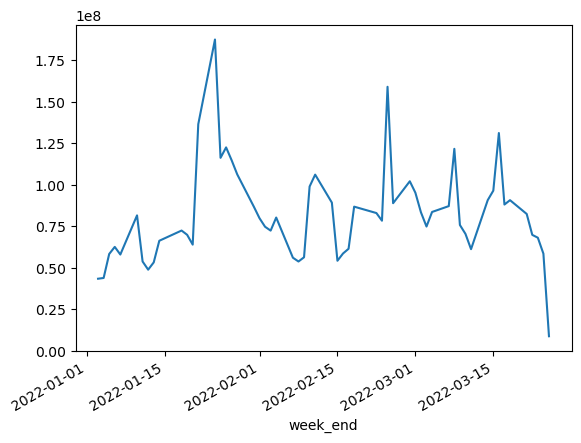

In [248]:
df.groupby('week_end')['volume'].sum().plot()

In [249]:
df.tail()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date,month_end,week_end,time-delta,close_diff
7261,2022-03-25 13:50:00,768843.0,451.3734,451.3881,451.4900,451.6300,451.10,1648216200000,10940,2022-03-25,2022-03-31 13:50:00,2022-03-25,300.0,0.000222
7262,2022-03-25 13:55:00,654224.0,451.0207,451.5100,450.8601,451.5400,450.64,1648216500000,8177,2022-03-25,2022-03-31 13:55:00,2022-03-25,300.0,-0.001395
7263,2022-03-25 14:00:00,657433.0,450.7049,450.8800,450.8000,451.0300,450.45,1648216800000,8871,2022-03-25,2022-03-31 14:00:00,2022-03-25,300.0,-0.000133
7264,2022-03-25 14:05:00,507110.0,450.9019,450.7901,451.1650,451.2400,450.64,1648217100000,7328,2022-03-25,2022-03-31 14:05:00,2022-03-25,300.0,0.000810
7265,2022-03-25 14:10:00,793393.0,450.9671,451.1700,451.0400,451.4345,451.04,1648217400000,6891,2022-03-25,2022-03-31 14:10:00,2022-03-25,300.0,-0.000277


<AxesSubplot: xlabel='datetime'>

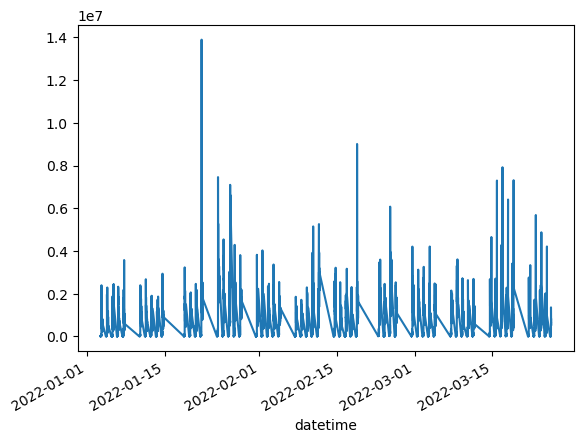

In [253]:
df.set_index('datetime')['volume'].plot()

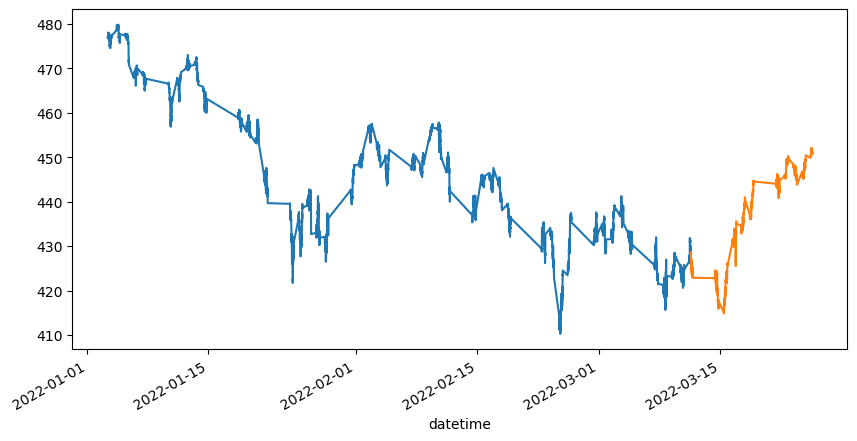

In [254]:
fig,axes = plt.subplots(1,1,figsize=[10,5])

df.set_index('datetime')['close'][:6000].plot(ax=axes,label='train')
df.set_index('datetime')['close'][6000:].plot(ax=axes,label='test')
plt.savefig('SPY_price.png',dpi=200)
plt.show()

In [255]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = int(2*(60/5))

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<LOOKBACK:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<HORIZON:
        finish = True
        t+=1
        continue
    
    lookback_data = df.loc[t-LOOKBACK:t,['volume','close','open','high','low']]
    lookback_data.loc[:,['close','open',
            'high','low']] = lookback_data.loc[:,['close','open',
                                                  'high','low']].div(lookback_data.iloc[-1,1]).values
    
    lookback_data.loc[:,'volume'] = lookback_data.loc[:,'volume']/(1.4*10**7)
    outcome_data = df.loc[t+1:t+HORIZON+1,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+HORIZON+1,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1


y = np.array(y).reshape(-1,1)
X = np.stack(X)

7266 ticks found


In [256]:
y = np.array(y).reshape(-1,1)
y.shape

(7237, 1)

In [257]:
growth = np.array(growth).reshape(-1,1)
growth.shape

(7237, 1)

In [258]:
X = np.stack(X)
X.shape

(7237, 25, 5)

In [259]:
X_train = X[:4000]
X_test = X[4000:]

y_train = y[:4000]
y_test = y[4000:]

growth_train = growth[:4000]
growth_test = growth[4000:]

with open('./data/X_train_2.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test_2.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train_2.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test_2.npy','wb') as f:
    np.save(f,X_test)

<a id='neural_network'></a>
## 1.0 Neural Network

In [260]:
import tensorflow as tf
from tensorflow import keras

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# with open('./data/X_train_2.npy','rb') as f:
#     X_train = np.load(f).astype('float32')
    
# with open('./data/X_test_2.npy','rb') as f:
#     X_test = np.load(f).astype('float32')
    
# with open('./data/y_train_2.npy','rb') as f:
#     y_train = np.load(f).astype('float32')

# with open('./data/y_test_2.npy','rb') as f:
#     y_test = np.load(f).astype('float32')

In [261]:
X_train.shape

(4000, 25, 5)

In [262]:
y_train.shape

(4000, 1)

In [263]:
X_test.shape

(3237, 25, 5)

In [264]:
y_test.shape

(3237, 1)

In [265]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2])),
    #keras.layers.Dense(21,activation='relu'),
    keras.layers.Dense(20,activation='sigmoid'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [266]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [267]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]

In [268]:
history = model.fit(X_train,y_train,batch_size=50,epochs=120,verbose=2,validation_data=(X_test,y_test))

Epoch 1/120


2023-01-29 17:55:39.902760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 17:55:40.521283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 - 1s - loss: 0.2911 - auc: 0.4987 - val_loss: 0.2661 - val_auc: 0.5119 - 1s/epoch - 15ms/step
Epoch 2/120
80/80 - 1s - loss: 0.2213 - auc: 0.4729 - val_loss: 0.2343 - val_auc: 0.4995 - 764ms/epoch - 10ms/step
Epoch 3/120
80/80 - 1s - loss: 0.1978 - auc: 0.5343 - val_loss: 0.2249 - val_auc: 0.4997 - 756ms/epoch - 9ms/step
Epoch 4/120
80/80 - 1s - loss: 0.1893 - auc: 0.4610 - val_loss: 0.2222 - val_auc: 0.5004 - 770ms/epoch - 10ms/step
Epoch 5/120
80/80 - 1s - loss: 0.1859 - auc: 0.4832 - val_loss: 0.2216 - val_auc: 0.5015 - 765ms/epoch - 10ms/step
Epoch 6/120
80/80 - 1s - loss: 0.1843 - auc: 0.4822 - val_loss: 0.2216 - val_auc: 0.5530 - 766ms/epoch - 10ms/step
Epoch 7/120
80/80 - 1s - loss: 0.1835 - auc: 0.5002 - val_loss: 0.2219 - val_auc: 0.5000 - 768ms/epoch - 10ms/step
Epoch 8/120
80/80 - 1s - loss: 0.1831 - auc: 0.5207 - val_loss: 0.2221 - val_auc: 0.5568 - 764ms/epoch - 10ms/step
Epoch 9/120
80/80 - 1s - loss: 0.1828 - auc: 0.5272 - val_loss: 0.2224 - val_auc: 0.4995 - 771ms

Epoch 72/120
80/80 - 1s - loss: 0.1774 - auc: 0.7148 - val_loss: 0.2177 - val_auc: 0.6690 - 850ms/epoch - 11ms/step
Epoch 73/120
80/80 - 1s - loss: 0.1773 - auc: 0.6994 - val_loss: 0.2175 - val_auc: 0.6681 - 799ms/epoch - 10ms/step
Epoch 74/120
80/80 - 1s - loss: 0.1772 - auc: 0.7036 - val_loss: 0.2170 - val_auc: 0.6677 - 839ms/epoch - 10ms/step
Epoch 75/120
80/80 - 1s - loss: 0.1771 - auc: 0.7071 - val_loss: 0.2170 - val_auc: 0.6680 - 827ms/epoch - 10ms/step
Epoch 76/120
80/80 - 1s - loss: 0.1771 - auc: 0.6958 - val_loss: 0.2167 - val_auc: 0.6644 - 860ms/epoch - 11ms/step
Epoch 77/120
80/80 - 1s - loss: 0.1769 - auc: 0.6998 - val_loss: 0.2171 - val_auc: 0.6648 - 798ms/epoch - 10ms/step
Epoch 78/120
80/80 - 1s - loss: 0.1767 - auc: 0.7014 - val_loss: 0.2168 - val_auc: 0.6649 - 788ms/epoch - 10ms/step
Epoch 79/120
80/80 - 1s - loss: 0.1767 - auc: 0.6995 - val_loss: 0.2166 - val_auc: 0.6682 - 839ms/epoch - 10ms/step
Epoch 80/120
80/80 - 1s - loss: 0.1765 - auc: 0.7047 - val_loss: 0.2166 

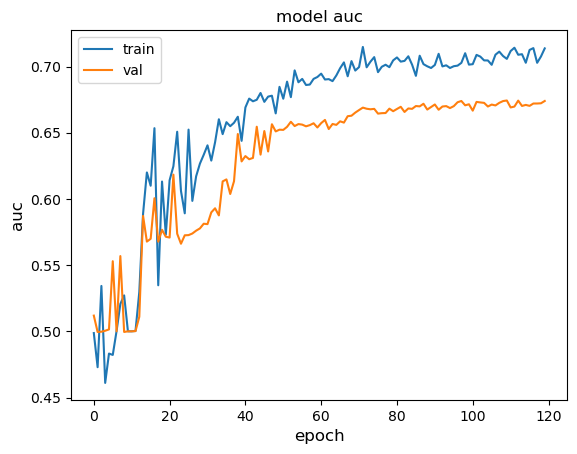

In [269]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

 86/102 [========================>.....] - ETA: 0s

2023-01-29 17:58:11.265554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 0s 2ms/step


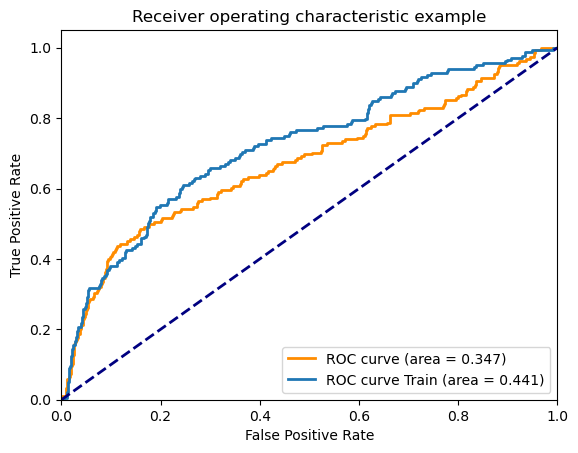

In [270]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [271]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Train Results is:{results.sum()}')

102/102 [==============================] - 0s 2ms/step
Train Results is:24.514649710275215


In [272]:
train_predictions.shape

(4000, 1)

In [273]:
percentiles.shape

(1,)

In [274]:
1>HORIZON

False

In [275]:
def run_sim(predictions,growth_results,p90):
    
    #p90 = np.percentile(predictions,90)
    
    results = list()
    last_bought_count = -1
    counter = 0
    for prediction,growth_result in zip(predictions.ravel(),growth_results.ravel()):
        counter+=1
        if prediction>p90:
            diff = counter-last_bought_count
            #print(counter,last_bought_count,diff)
            if (last_bought_count==-1):
                last_bought_count = counter
                results.append(growth_result)
            elif (diff>HORIZON):
                last_bought_count = counter
                results.append(growth_result)
    
    cumulative_gain = 1.0
    for i in results:
        cumulative_gain*=(1+i)
    
    return cumulative_gain

run_sim(train_predictions,growth_train,np.percentile(train_predictions,90))

1.0303264218901267

In [276]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = run_sim(test_predictions,growth_test,np.percentile(train_predictions,90))
print(f'Test Results is:{results}')

Test Results is:1.055075063822742


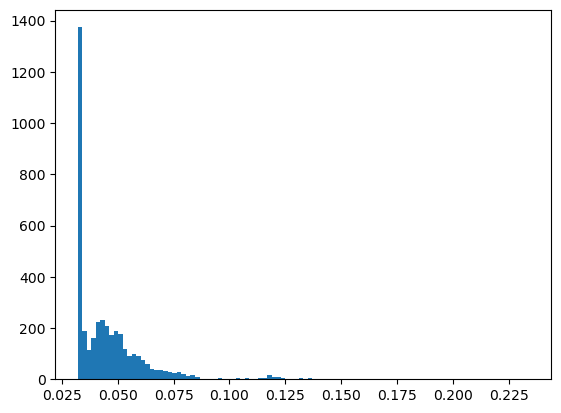

In [277]:
plt.hist(train_predictions,bins=100)
plt.show()

<a id='cnn'></a>
## 2.0 1D Convolutional NN

In [287]:
model = keras.Sequential([
    keras.layers.Conv1D(36,2,
                        activation='sigmoid',
                        input_shape=(X_train.shape[1],X_train.shape[2]),padding="valid",groups=1,
                        kernel_regularizer=tf.keras.regularizers.l2(l=.05)),
    #keras.layers.Conv1D(3,3,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    #keras.layers.Conv1D(6,2,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    keras.layers.Dense(10,activation='sigmoid'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [288]:
metrics = [
    tf.metrics.AUC(name='auc')
]

#odel.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [289]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [290]:
history = model.fit(X_train,y_train,batch_size=50,epochs=500,verbose=2,validation_data=(X_test,y_test))

Epoch 1/500


2023-01-29 18:09:58.036693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 18:09:59.018200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 - 2s - loss: 0.9666 - auc: 0.5068 - val_loss: 0.7261 - val_auc: 0.5000 - 2s/epoch - 22ms/step
Epoch 2/500
80/80 - 1s - loss: 0.8751 - auc: 0.6387 - val_loss: 0.6324 - val_auc: 0.6228 - 1s/epoch - 15ms/step
Epoch 3/500
80/80 - 1s - loss: 0.7672 - auc: 0.6625 - val_loss: 0.5797 - val_auc: 0.6540 - 1s/epoch - 15ms/step
Epoch 4/500
80/80 - 1s - loss: 0.6573 - auc: 0.6999 - val_loss: 0.5399 - val_auc: 0.5863 - 1s/epoch - 15ms/step
Epoch 5/500
80/80 - 1s - loss: 0.5673 - auc: 0.6802 - val_loss: 0.5070 - val_auc: 0.6028 - 1s/epoch - 15ms/step
Epoch 6/500
80/80 - 1s - loss: 0.5030 - auc: 0.6970 - val_loss: 0.4778 - val_auc: 0.6196 - 1s/epoch - 15ms/step
Epoch 7/500
80/80 - 1s - loss: 0.4567 - auc: 0.6970 - val_loss: 0.4517 - val_auc: 0.6377 - 1s/epoch - 15ms/step
Epoch 8/500
80/80 - 1s - loss: 0.4222 - auc: 0.7111 - val_loss: 0.4288 - val_auc: 0.6403 - 1s/epoch - 15ms/step
Epoch 9/500
80/80 - 1s - loss: 0.3944 - auc: 0.7006 - val_loss: 0.4084 - val_auc: 0.6374 - 1s/epoch - 14ms/step
Epoc

Epoch 74/500
80/80 - 1s - loss: 0.1735 - auc: 0.7073 - val_loss: 0.2113 - val_auc: 0.6706 - 1s/epoch - 14ms/step
Epoch 75/500
80/80 - 1s - loss: 0.1735 - auc: 0.7058 - val_loss: 0.2157 - val_auc: 0.6728 - 1s/epoch - 14ms/step
Epoch 76/500
80/80 - 1s - loss: 0.1738 - auc: 0.7048 - val_loss: 0.2112 - val_auc: 0.6743 - 1s/epoch - 14ms/step
Epoch 77/500
80/80 - 1s - loss: 0.1737 - auc: 0.7028 - val_loss: 0.2115 - val_auc: 0.6795 - 1s/epoch - 14ms/step
Epoch 78/500
80/80 - 1s - loss: 0.1732 - auc: 0.7090 - val_loss: 0.2194 - val_auc: 0.6731 - 1s/epoch - 14ms/step
Epoch 79/500
80/80 - 1s - loss: 0.1730 - auc: 0.7072 - val_loss: 0.2153 - val_auc: 0.6744 - 1s/epoch - 14ms/step
Epoch 80/500
80/80 - 1s - loss: 0.1733 - auc: 0.7084 - val_loss: 0.2215 - val_auc: 0.6739 - 1s/epoch - 14ms/step
Epoch 81/500
80/80 - 1s - loss: 0.1732 - auc: 0.7052 - val_loss: 0.2110 - val_auc: 0.6797 - 1s/epoch - 14ms/step
Epoch 82/500
80/80 - 1s - loss: 0.1730 - auc: 0.7044 - val_loss: 0.2101 - val_auc: 0.6766 - 1s/e

80/80 - 1s - loss: 0.1695 - auc: 0.7189 - val_loss: 0.2215 - val_auc: 0.6937 - 1s/epoch - 14ms/step
Epoch 147/500
80/80 - 1s - loss: 0.1692 - auc: 0.7260 - val_loss: 0.2236 - val_auc: 0.6948 - 1s/epoch - 14ms/step
Epoch 148/500
80/80 - 1s - loss: 0.1689 - auc: 0.7274 - val_loss: 0.2274 - val_auc: 0.6956 - 1s/epoch - 14ms/step
Epoch 149/500
80/80 - 1s - loss: 0.1692 - auc: 0.7258 - val_loss: 0.2193 - val_auc: 0.6904 - 1s/epoch - 15ms/step
Epoch 150/500
80/80 - 1s - loss: 0.1690 - auc: 0.7229 - val_loss: 0.2091 - val_auc: 0.6952 - 1s/epoch - 14ms/step
Epoch 151/500
80/80 - 1s - loss: 0.1690 - auc: 0.7241 - val_loss: 0.2067 - val_auc: 0.6972 - 1s/epoch - 14ms/step
Epoch 152/500
80/80 - 1s - loss: 0.1688 - auc: 0.7214 - val_loss: 0.2085 - val_auc: 0.6956 - 1s/epoch - 14ms/step
Epoch 153/500
80/80 - 1s - loss: 0.1690 - auc: 0.7285 - val_loss: 0.2098 - val_auc: 0.6879 - 1s/epoch - 14ms/step
Epoch 154/500
80/80 - 1s - loss: 0.1688 - auc: 0.7295 - val_loss: 0.2314 - val_auc: 0.6950 - 1s/epoch 

Epoch 218/500
80/80 - 1s - loss: 0.1669 - auc: 0.7387 - val_loss: 0.2095 - val_auc: 0.6960 - 1s/epoch - 14ms/step
Epoch 219/500
80/80 - 1s - loss: 0.1674 - auc: 0.7378 - val_loss: 0.2119 - val_auc: 0.7018 - 1s/epoch - 15ms/step
Epoch 220/500
80/80 - 1s - loss: 0.1678 - auc: 0.7319 - val_loss: 0.2040 - val_auc: 0.7001 - 1s/epoch - 14ms/step
Epoch 221/500
80/80 - 1s - loss: 0.1678 - auc: 0.7335 - val_loss: 0.3144 - val_auc: 0.6989 - 1s/epoch - 14ms/step
Epoch 222/500
80/80 - 1s - loss: 0.1676 - auc: 0.7330 - val_loss: 0.2232 - val_auc: 0.6960 - 1s/epoch - 14ms/step
Epoch 223/500
80/80 - 1s - loss: 0.1671 - auc: 0.7337 - val_loss: 0.2214 - val_auc: 0.6997 - 1s/epoch - 14ms/step
Epoch 224/500
80/80 - 1s - loss: 0.1675 - auc: 0.7357 - val_loss: 0.2041 - val_auc: 0.7012 - 1s/epoch - 14ms/step
Epoch 225/500
80/80 - 1s - loss: 0.1670 - auc: 0.7372 - val_loss: 0.2231 - val_auc: 0.6974 - 1s/epoch - 14ms/step
Epoch 226/500
80/80 - 1s - loss: 0.1673 - auc: 0.7319 - val_loss: 0.2091 - val_auc: 0.69

Epoch 290/500
80/80 - 1s - loss: 0.1666 - auc: 0.7312 - val_loss: 0.2032 - val_auc: 0.7043 - 1s/epoch - 14ms/step
Epoch 291/500
80/80 - 1s - loss: 0.1668 - auc: 0.7276 - val_loss: 0.2051 - val_auc: 0.7019 - 1s/epoch - 14ms/step
Epoch 292/500
80/80 - 1s - loss: 0.1664 - auc: 0.7353 - val_loss: 0.2135 - val_auc: 0.7017 - 1s/epoch - 14ms/step
Epoch 293/500
80/80 - 1s - loss: 0.1657 - auc: 0.7377 - val_loss: 0.2037 - val_auc: 0.7018 - 1s/epoch - 14ms/step
Epoch 294/500
80/80 - 1s - loss: 0.1660 - auc: 0.7331 - val_loss: 0.2058 - val_auc: 0.7007 - 1s/epoch - 14ms/step
Epoch 295/500
80/80 - 1s - loss: 0.1662 - auc: 0.7293 - val_loss: 0.2119 - val_auc: 0.7029 - 1s/epoch - 14ms/step
Epoch 296/500
80/80 - 1s - loss: 0.1658 - auc: 0.7316 - val_loss: 0.2278 - val_auc: 0.7003 - 1s/epoch - 14ms/step
Epoch 297/500
80/80 - 1s - loss: 0.1663 - auc: 0.7341 - val_loss: 0.2047 - val_auc: 0.7048 - 1s/epoch - 15ms/step
Epoch 298/500
80/80 - 1s - loss: 0.1664 - auc: 0.7304 - val_loss: 0.2053 - val_auc: 0.70

Epoch 362/500
80/80 - 1s - loss: 0.1653 - auc: 0.7325 - val_loss: 0.2031 - val_auc: 0.7067 - 1s/epoch - 14ms/step
Epoch 363/500
80/80 - 1s - loss: 0.1652 - auc: 0.7351 - val_loss: 0.2080 - val_auc: 0.7043 - 1s/epoch - 14ms/step
Epoch 364/500
80/80 - 1s - loss: 0.1654 - auc: 0.7404 - val_loss: 0.2180 - val_auc: 0.7044 - 1s/epoch - 14ms/step
Epoch 365/500
80/80 - 1s - loss: 0.1654 - auc: 0.7297 - val_loss: 0.2203 - val_auc: 0.7044 - 1s/epoch - 14ms/step
Epoch 366/500
80/80 - 1s - loss: 0.1655 - auc: 0.7417 - val_loss: 0.2169 - val_auc: 0.7035 - 1s/epoch - 15ms/step
Epoch 367/500
80/80 - 1s - loss: 0.1652 - auc: 0.7380 - val_loss: 0.2251 - val_auc: 0.6961 - 1s/epoch - 15ms/step
Epoch 368/500
80/80 - 1s - loss: 0.1652 - auc: 0.7378 - val_loss: 0.2178 - val_auc: 0.7057 - 1s/epoch - 15ms/step
Epoch 369/500
80/80 - 1s - loss: 0.1654 - auc: 0.7368 - val_loss: 0.2233 - val_auc: 0.7033 - 1s/epoch - 15ms/step
Epoch 370/500
80/80 - 1s - loss: 0.1657 - auc: 0.7297 - val_loss: 0.2150 - val_auc: 0.69

Epoch 434/500
80/80 - 1s - loss: 0.1645 - auc: 0.7432 - val_loss: 0.2718 - val_auc: 0.7041 - 1s/epoch - 14ms/step
Epoch 435/500
80/80 - 1s - loss: 0.1647 - auc: 0.7374 - val_loss: 0.2231 - val_auc: 0.7063 - 1s/epoch - 14ms/step
Epoch 436/500
80/80 - 1s - loss: 0.1645 - auc: 0.7430 - val_loss: 0.2382 - val_auc: 0.7111 - 1s/epoch - 14ms/step
Epoch 437/500
80/80 - 1s - loss: 0.1644 - auc: 0.7457 - val_loss: 0.2025 - val_auc: 0.7086 - 1s/epoch - 14ms/step
Epoch 438/500
80/80 - 1s - loss: 0.1643 - auc: 0.7412 - val_loss: 0.2124 - val_auc: 0.7025 - 1s/epoch - 14ms/step
Epoch 439/500
80/80 - 1s - loss: 0.1640 - auc: 0.7438 - val_loss: 0.2054 - val_auc: 0.7081 - 1s/epoch - 14ms/step
Epoch 440/500
80/80 - 1s - loss: 0.1645 - auc: 0.7449 - val_loss: 0.2125 - val_auc: 0.7057 - 1s/epoch - 14ms/step
Epoch 441/500
80/80 - 1s - loss: 0.1644 - auc: 0.7415 - val_loss: 0.2028 - val_auc: 0.7065 - 1s/epoch - 14ms/step
Epoch 442/500
80/80 - 1s - loss: 0.1640 - auc: 0.7425 - val_loss: 0.2333 - val_auc: 0.70

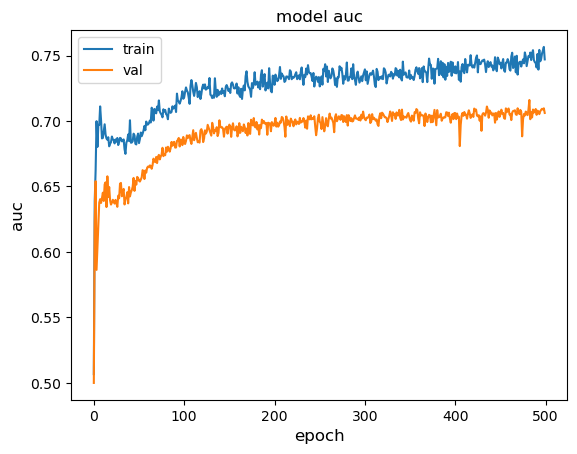

In [291]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

 70/102 [===================>..........] - ETA: 0s

2023-01-29 19:08:13.107744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 0s 2ms/step


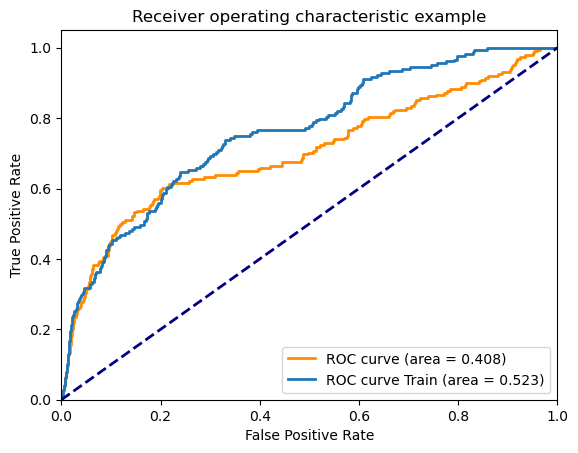

In [292]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [293]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
results = run_sim(train_predictions,growth_train,np.percentile(train_predictions,90))
print(f'Results is:{results}')

102/102 [==============================] - 0s 2ms/step
Results is:1.0075207884875481


In [294]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = run_sim(test_predictions,growth_test,np.percentile(train_predictions,90))
print(f'Test Results is:{results}')

Test Results is:1.082151517569654


Tops out at 0.35....

<a id='ltsm'></a>
## 3.0 LTSM
Not even sure this is right..

In [299]:
from tensorflow.keras.layers import LSTM
from tensorflow import keras

lookback = 20
model = keras.Sequential([
    keras.layers.LSTM(20,input_shape=(25,5)),
    keras.layers.Dense(5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [300]:
X_train.shape

(4000, 25, 5)

In [301]:
import tensorflow as tf

metrics = [tf.metrics.AUC(name='auc')]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100


2023-01-29 19:10:32.984241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:10:33.074736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:10:33.253811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:10:34.531279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:10:34.593244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 - 3s - loss: 0.4744 - auc: 0.5007 - val_loss: 0.3933 - val_auc: 0.5013 - 3s/epoch - 33ms/step
Epoch 2/100
80/80 - 1s - loss: 0.3214 - auc: 0.4902 - val_loss: 0.2919 - val_auc: 0.4879 - 1s/epoch - 18ms/step
Epoch 3/100
80/80 - 2s - loss: 0.2431 - auc: 0.5195 - val_loss: 0.2462 - val_auc: 0.5065 - 2s/epoch - 19ms/step
Epoch 4/100
80/80 - 2s - loss: 0.2077 - auc: 0.4826 - val_loss: 0.2286 - val_auc: 0.5269 - 2s/epoch - 20ms/step
Epoch 5/100
80/80 - 1s - loss: 0.1926 - auc: 0.5086 - val_loss: 0.2229 - val_auc: 0.5005 - 1s/epoch - 18ms/step
Epoch 6/100
80/80 - 1s - loss: 0.1863 - auc: 0.5255 - val_loss: 0.2215 - val_auc: 0.5020 - 1s/epoch - 18ms/step
Epoch 7/100
80/80 - 1s - loss: 0.1840 - auc: 0.4731 - val_loss: 0.2217 - val_auc: 0.5000 - 1s/epoch - 18ms/step
Epoch 8/100
80/80 - 2s - loss: 0.1830 - auc: 0.5120 - val_loss: 0.2222 - val_auc: 0.5108 - 2s/epoch - 19ms/step
Epoch 9/100
80/80 - 2s - loss: 0.1827 - auc: 0.4996 - val_loss: 0.2226 - val_auc: 0.5000 - 2s/epoch - 19ms/step
Epoc

Epoch 74/100
80/80 - 2s - loss: 0.1712 - auc: 0.6921 - val_loss: 0.2104 - val_auc: 0.6714 - 2s/epoch - 20ms/step
Epoch 75/100
80/80 - 2s - loss: 0.1708 - auc: 0.6961 - val_loss: 0.2114 - val_auc: 0.6708 - 2s/epoch - 19ms/step
Epoch 76/100
80/80 - 2s - loss: 0.1697 - auc: 0.7112 - val_loss: 0.2103 - val_auc: 0.6735 - 2s/epoch - 19ms/step
Epoch 77/100
80/80 - 1s - loss: 0.1695 - auc: 0.7102 - val_loss: 0.2121 - val_auc: 0.6704 - 1s/epoch - 19ms/step
Epoch 78/100
80/80 - 2s - loss: 0.1698 - auc: 0.7091 - val_loss: 0.2102 - val_auc: 0.6699 - 2s/epoch - 19ms/step
Epoch 79/100
80/80 - 2s - loss: 0.1695 - auc: 0.7072 - val_loss: 0.2099 - val_auc: 0.6731 - 2s/epoch - 19ms/step
Epoch 80/100
80/80 - 2s - loss: 0.1693 - auc: 0.7117 - val_loss: 0.2103 - val_auc: 0.6738 - 2s/epoch - 19ms/step
Epoch 81/100
80/80 - 1s - loss: 0.1693 - auc: 0.7089 - val_loss: 0.2106 - val_auc: 0.6786 - 1s/epoch - 18ms/step
Epoch 82/100
80/80 - 1s - loss: 0.1692 - auc: 0.7109 - val_loss: 0.2106 - val_auc: 0.6810 - 1s/e

In [302]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [303]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100
80/80 - 1s - loss: 0.1672 - auc: 0.7272 - val_loss: 0.2082 - val_auc: 0.6913 - 1s/epoch - 18ms/step
Epoch 2/100
80/80 - 1s - loss: 0.1669 - auc: 0.7304 - val_loss: 0.2083 - val_auc: 0.6882 - 1s/epoch - 18ms/step
Epoch 3/100
80/80 - 1s - loss: 0.1669 - auc: 0.7348 - val_loss: 0.2070 - val_auc: 0.6903 - 1s/epoch - 18ms/step
Epoch 4/100
80/80 - 1s - loss: 0.1669 - auc: 0.7287 - val_loss: 0.2061 - val_auc: 0.6929 - 1s/epoch - 18ms/step
Epoch 5/100
80/80 - 1s - loss: 0.1670 - auc: 0.7303 - val_loss: 0.2078 - val_auc: 0.6918 - 1s/epoch - 18ms/step
Epoch 6/100
80/80 - 1s - loss: 0.1669 - auc: 0.7349 - val_loss: 0.2066 - val_auc: 0.6902 - 1s/epoch - 18ms/step
Epoch 7/100
80/80 - 2s - loss: 0.1673 - auc: 0.7289 - val_loss: 0.2068 - val_auc: 0.6909 - 2s/epoch - 19ms/step
Epoch 8/100
80/80 - 1s - loss: 0.1669 - auc: 0.7316 - val_loss: 0.2062 - val_auc: 0.6935 - 1s/epoch - 19ms/step
Epoch 9/100
80/80 - 1s - loss: 0.1668 - auc: 0.7285 - val_loss: 0.2087 - val_auc: 0.6904 - 1s/epoch - 19

Epoch 74/100
80/80 - 1s - loss: 0.1647 - auc: 0.7527 - val_loss: 0.2041 - val_auc: 0.6963 - 1s/epoch - 18ms/step
Epoch 75/100
80/80 - 1s - loss: 0.1648 - auc: 0.7484 - val_loss: 0.2049 - val_auc: 0.7000 - 1s/epoch - 18ms/step
Epoch 76/100
80/80 - 1s - loss: 0.1651 - auc: 0.7481 - val_loss: 0.2055 - val_auc: 0.6971 - 1s/epoch - 18ms/step
Epoch 77/100
80/80 - 1s - loss: 0.1645 - auc: 0.7553 - val_loss: 0.2042 - val_auc: 0.6973 - 1s/epoch - 18ms/step
Epoch 78/100
80/80 - 1s - loss: 0.1646 - auc: 0.7533 - val_loss: 0.2043 - val_auc: 0.6978 - 1s/epoch - 18ms/step
Epoch 79/100
80/80 - 1s - loss: 0.1648 - auc: 0.7508 - val_loss: 0.2043 - val_auc: 0.6979 - 1s/epoch - 18ms/step
Epoch 80/100
80/80 - 1s - loss: 0.1648 - auc: 0.7559 - val_loss: 0.2039 - val_auc: 0.6968 - 1s/epoch - 18ms/step
Epoch 81/100
80/80 - 1s - loss: 0.1644 - auc: 0.7529 - val_loss: 0.2076 - val_auc: 0.7078 - 1s/epoch - 18ms/step
Epoch 82/100
80/80 - 1s - loss: 0.1643 - auc: 0.7576 - val_loss: 0.2039 - val_auc: 0.7018 - 1s/e

In [304]:
2*0.67-1

0.3400000000000001

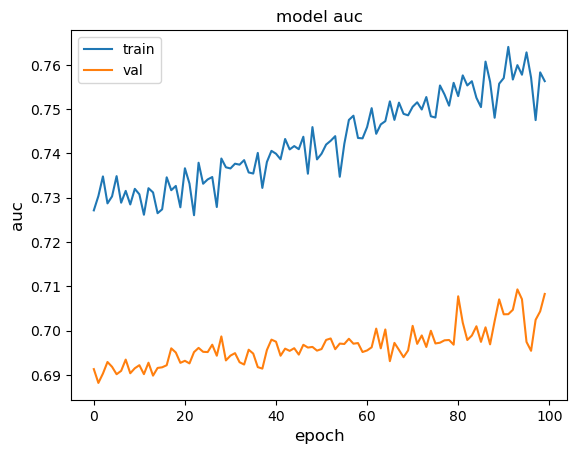

In [305]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

 20/102 [====>.........................] - ETA: 0s

2023-01-29 19:15:29.056787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:15:29.088449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 1s 5ms/step


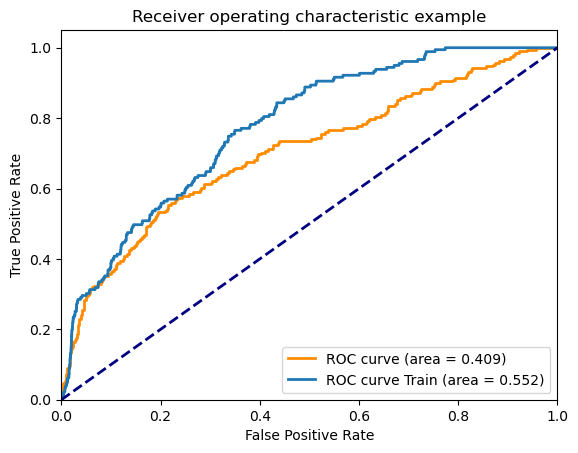

In [306]:
plot_roc_curve(X_train,y_train,X_test,y_test,model)

In [307]:
input_series = X
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
results = run_sim(train_predictions,growth_train,np.percentile(train_predictions,90))
print(f'Results is:{results}')

102/102 [==============================] - 1s 5ms/step
Results is:1.0216324723701862


In [308]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = run_sim(test_predictions,growth_test,np.percentile(train_predictions,90))
print(f'Test Results is:{results}')

Test Results is:1.0581868219015453


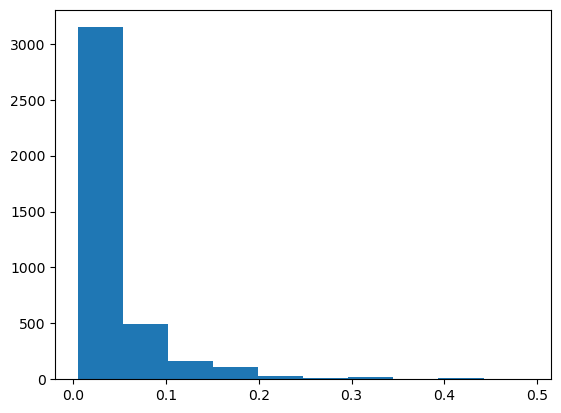

In [309]:
plt.hist(train_predictions)
plt.show()

<a id='CNN_noncolor'></a>
## 4.0 Conv2D non-color image (i.e. close only)
The image is essentialy the plot of the highs, lows, close, and open. Need to do some manipulation here.

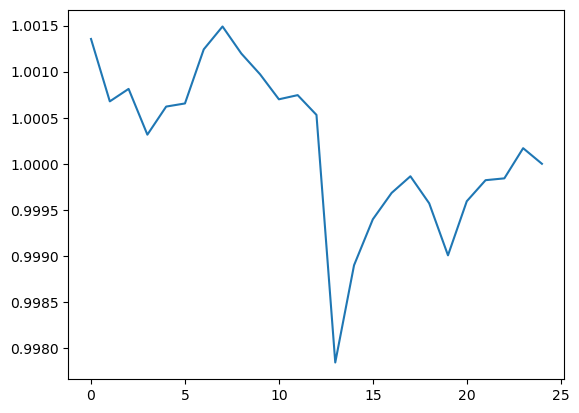

In [310]:
plt.plot(X_train[-1,:,1])
plt.show()

In [314]:
levels = np.arange(0.996,1.001,0.0001)
levels = [-np.inf]+levels.tolist()+[np.inf]
n_levels = len(levels)
labels = np.arange(n_levels-1)

Y = pd.cut(X_train[0,:,1],levels,labels=labels[::-1])

y_resolution = len(levels)
X = np.arange(0,len(X_train[0,:,1]))

blank = np.zeros( (n_levels,25))
for n,(x,y) in enumerate(zip(X,Y)):
    blank[y,x] = X_train[0,:,1][n]

In [318]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    series = series.ravel()
    levels = [-np.inf]+np.arange(1-0.003,1+0.003,0.00002).tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)
    Y = pd.cut(series,levels,labels=labels[::-1])
    
    y_resolution = len(levels)
    X = np.arange(0,len(series))
    
    blank = np.zeros( (n_levels,25))
    for n,(x,y) in enumerate(zip(X,Y)):
        #blank[y,x] = series[n]
        #print(x,y)
        blank[y,x] = 255
        
    return blank

In [319]:
def plot_time_series(series):
    np_img = convert_time_series_img(series,0.994,1.006,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [320]:
x = convert_time_series_img(X_train[0,:,1],0.994,1.006,0.0001)

In [321]:
X_train[0,:,1]

array([0.9976569 , 0.9974059 , 0.9974895 , 0.9974686 , 0.9981799 ,
       0.99843097, 0.9982636 , 0.99832636, 0.9987448 , 0.998682  ,
       0.99899584, 0.99916315, 0.99916315, 0.9993096 , 0.9991841 ,
       0.9994142 , 0.9992259 , 0.9994979 , 0.9997908 , 1.        ,
       0.99993724, 0.99993724, 1.0001255 , 0.99976987, 1.        ],
      dtype=float32)

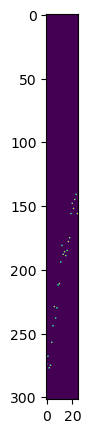

In [322]:
plot_time_series(X_train[0,:,2])

In [323]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img(X_train[x,:,1],0.98,1.02,0.0001) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

Hoooooo-rah!!!! Looks like its working.

![SegmentLocal](array.gif "segment")

In [326]:
img_train = np.stack([convert_time_series_img(X_train[x,:,1],0.99,1.01,0.0001).reshape(203,25,1) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img(X_test[x,:,1],0.99,1.01,0.0001).reshape(203,25,1) for x in range(len(X_test))])

ValueError: cannot reshape array of size 7550 into shape (203,25,1)

In [327]:
plt.imshow(img_train[-1])

NameError: name 'img_train' is not defined

In [328]:
model = keras.Sequential(
    [
        keras.Input(shape=(203, 21, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        #layers.Dense(200, activation="sigmoid"),
        #layers.Dropout(0.9),
        #layers.Dense(20, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 201, 19, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 9, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 7, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 3, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 1, 32)         18464     
                                                                 
 flatten_7 (Flatten)         (None, 608)             

In [329]:
batch_size = 200
epochs = 30

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

NameError: name 'img_train' is not defined

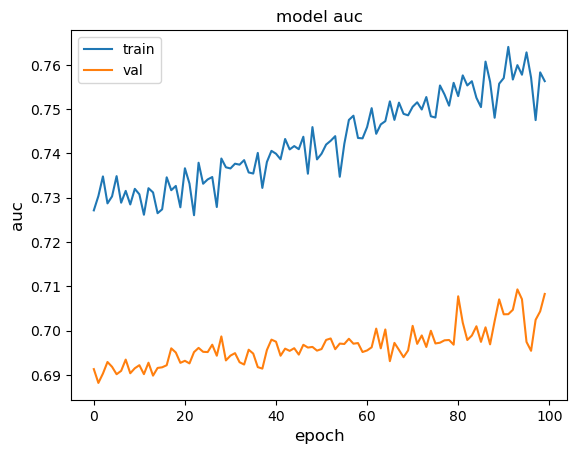

In [330]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [331]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

NameError: name 'img_train' is not defined

In [332]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

NameError: name 'img_train' is not defined

In [333]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')

Test Results is:35.76497463292577


The probability distribution looks nice!!!

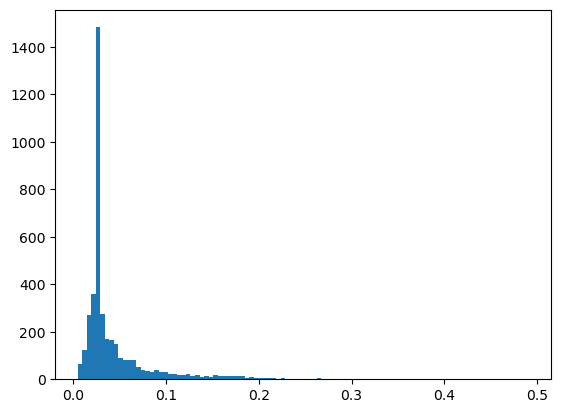

In [334]:
plt.hist(train_predictions,bins=100)
plt.show()

In [335]:
for n,v in enumerate(train_predictions):
    if v>0.3:
        print(n)

1691
1692
1693
1694
1695
1696
1697
1698
1814
1815
1816
1817
1818
1819
1820
1821
1945
1946
2123
2124
2125
2126
2127
2128
2129
3626
3627
3628
3629
3630
3631


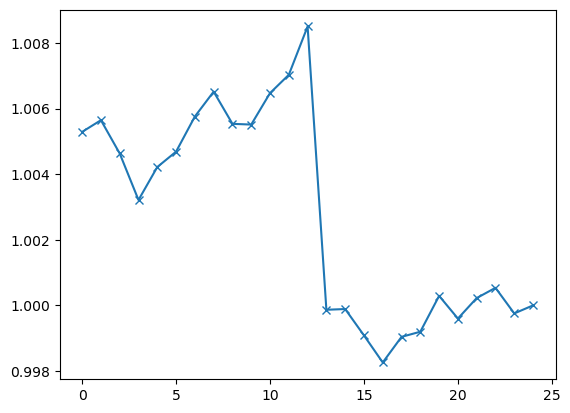

In [336]:
plt.plot(X_train[3022,:,1],marker='x')

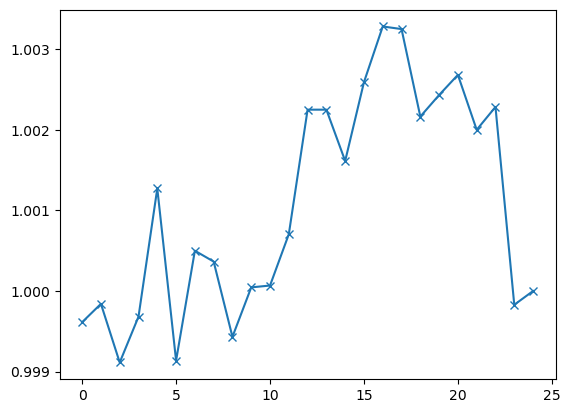

In [337]:
plt.plot(X_train[3745,:,1],marker='x')

In [338]:
plt.plot(X_train[5515,:,1],marker='x')

IndexError: index 5515 is out of bounds for axis 0 with size 4000

<a id='CNN_candlestick'></a>
## 5.0 Conv2D with color (still no volume)

In [342]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = [-np.inf]+np.arange(1-0.003,1+0.003,0.00002).tolist()+[np.inf]
    #levels = np.arange(lower_bound,upper_bound,resolution)
    #levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,21,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
        
    return blank

def convert_time_series_img2(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = [-np.inf]+np.arange(1-0.003,1+0.003,0.00002).tolist()+[np.inf]
    #levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,25,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
        
    return blank



def plot_time_series(series):
    np_img = convert_time_series_img2(series,0.994,1.006,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [343]:
X_train.shape

(4000, 25, 5)

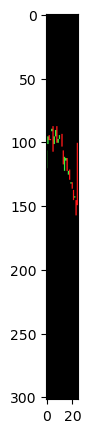

In [344]:
plot_time_series(X_train[18,:,:])

Just checking that the color of the candles looks right - appears to be...

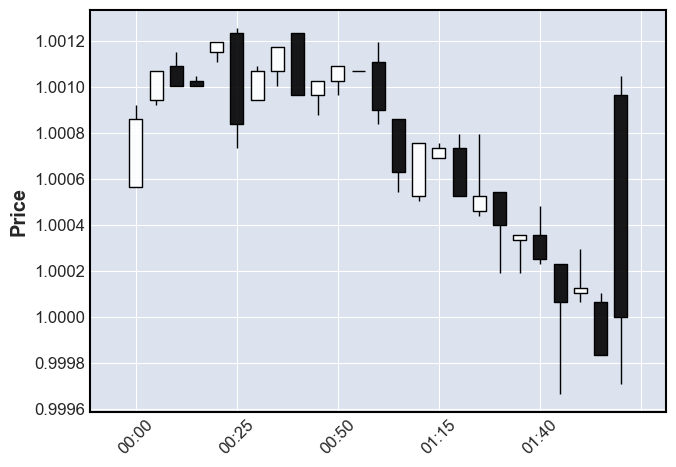

In [345]:
import mplfinance as mpf
intervals = pd.DataFrame(X_train[18,:,:],columns=['volume','close','open','high','low'])
intervals.index = pd.date_range('2021-06-01',periods=len(intervals.index),freq='5min')
mpf.plot(intervals,type='candle')

Creating a pretty gif so i can show off.

In [346]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img2(X_train[x,:,:],0.99,1.01,0.0001).astype(np.uint8) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array_color.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [347]:
img_train = np.stack([convert_time_series_img2(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img2(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))])

In [349]:
model = keras.Sequential(
    [
        keras.Input(shape=(302, 25, 3)),
        keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        #keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        #keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        #layers.Dense(200, activation="sigmoid"),
        #layers.Dropout(0.9),
        keras.layers.Dense(20, activation="sigmoid"),
        keras.layers.Dropout(0.9),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 300, 23, 16)       448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 11, 16)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 9, 32)         4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 4, 32)        0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dropout_3 (Dropout)         (None, 4096)            

In [352]:
batch_size = 200
epochs = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

Epoch 1/200


2023-01-29 19:36:14.092378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.1938 - auc: 0.4899

2023-01-29 19:36:15.449528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 2s 79ms/step - loss: 0.1938 - auc: 0.4899 - val_loss: 0.2224 - val_auc: 0.5093
Epoch 2/200
20/20 [==============================] - 1s 54ms/step - loss: 0.1889 - auc: 0.5356 - val_loss: 0.2228 - val_auc: 0.5083
Epoch 3/200
20/20 [==============================] - 1s 48ms/step - loss: 0.1875 - auc: 0.5093 - val_loss: 0.2237 - val_auc: 0.5046
Epoch 4/200
20/20 [==============================] - 1s 48ms/step - loss: 0.1847 - auc: 0.5281 - val_loss: 0.2224 - val_auc: 0.5084
Epoch 5/200
20/20 [==============================] - 1s 49ms/step - loss: 0.1859 - auc: 0.4949 - val_loss: 0.2227 - val_auc: 0.5063
Epoch 6/200
20/20 [==============================] - 1s 49ms/step - loss: 0.1856 - auc: 0.5267 - val_loss: 0.2229 - val_auc: 0.5057
Epoch 7/200
20/20 [==============================] - 1s 49ms/step - loss: 0.1835 - auc: 0.5417 - val_loss: 0.2239 - val_auc: 0.5120
Epoch 8/200
20/20 [==============================] - 1s 50ms/step - loss: 0.1865 - auc: 

Epoch 63/200
20/20 [==============================] - 1s 48ms/step - loss: 0.1845 - auc: 0.5177 - val_loss: 0.2238 - val_auc: 0.5057
Epoch 64/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1870 - auc: 0.4578 - val_loss: 0.2266 - val_auc: 0.5210
Epoch 65/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1840 - auc: 0.5147 - val_loss: 0.2231 - val_auc: 0.5001
Epoch 66/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1849 - auc: 0.4933 - val_loss: 0.2239 - val_auc: 0.5090
Epoch 67/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1853 - auc: 0.4666 - val_loss: 0.2235 - val_auc: 0.5090
Epoch 68/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1844 - auc: 0.4957 - val_loss: 0.2234 - val_auc: 0.4878
Epoch 69/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1844 - auc: 0.5100 - val_loss: 0.2277 - val_auc: 0.5102
Epoch 70/200
20/20 [==============================] - 1s 48ms/step - 

20/20 [==============================] - 1s 47ms/step - loss: 0.1844 - auc: 0.4988 - val_loss: 0.2253 - val_auc: 0.4982
Epoch 125/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1840 - auc: 0.5181 - val_loss: 0.2237 - val_auc: 0.5013
Epoch 126/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1847 - auc: 0.5054 - val_loss: 0.2244 - val_auc: 0.4986
Epoch 127/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1849 - auc: 0.5006 - val_loss: 0.2247 - val_auc: 0.5034
Epoch 128/200
20/20 [==============================] - 1s 49ms/step - loss: 0.1844 - auc: 0.5136 - val_loss: 0.2236 - val_auc: 0.5067
Epoch 129/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1860 - auc: 0.4807 - val_loss: 0.2245 - val_auc: 0.5216
Epoch 130/200
20/20 [==============================] - 1s 48ms/step - loss: 0.1837 - auc: 0.5107 - val_loss: 0.2241 - val_auc: 0.5002
Epoch 131/200
20/20 [==============================] - 1s 48ms/step - loss: 

20/20 [==============================] - 1s 47ms/step - loss: 0.1838 - auc: 0.4823 - val_loss: 0.2243 - val_auc: 0.4955
Epoch 186/200
20/20 [==============================] - 1s 48ms/step - loss: 0.1849 - auc: 0.5036 - val_loss: 0.2227 - val_auc: 0.5003
Epoch 187/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1839 - auc: 0.5090 - val_loss: 0.2257 - val_auc: 0.4947
Epoch 188/200
20/20 [==============================] - 1s 49ms/step - loss: 0.1846 - auc: 0.5186 - val_loss: 0.2232 - val_auc: 0.5156
Epoch 189/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1841 - auc: 0.5231 - val_loss: 0.2249 - val_auc: 0.4946
Epoch 190/200
20/20 [==============================] - 1s 48ms/step - loss: 0.1861 - auc: 0.4425 - val_loss: 0.2239 - val_auc: 0.4900
Epoch 191/200
20/20 [==============================] - 1s 47ms/step - loss: 0.1847 - auc: 0.4694 - val_loss: 0.2228 - val_auc: 0.5026
Epoch 192/200
20/20 [==============================] - 1s 48ms/step - loss: 

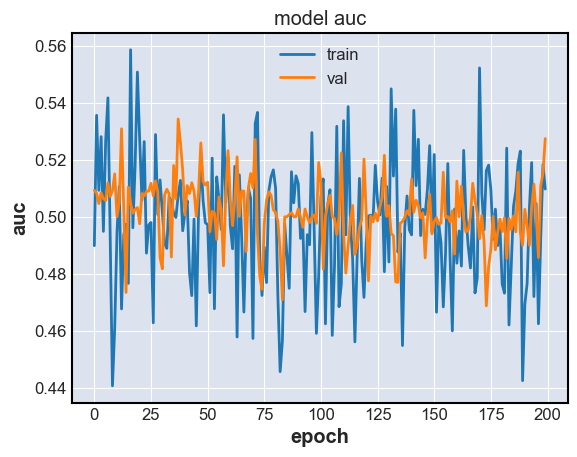

In [353]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

 33/102 [========>.....................] - ETA: 0s

2023-01-29 19:39:34.931427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 0s 3ms/step


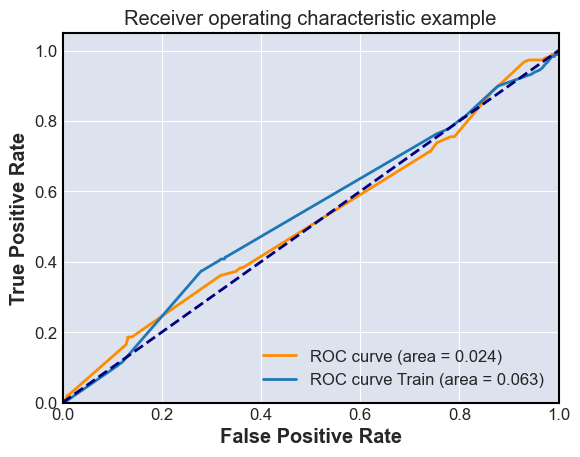

In [354]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

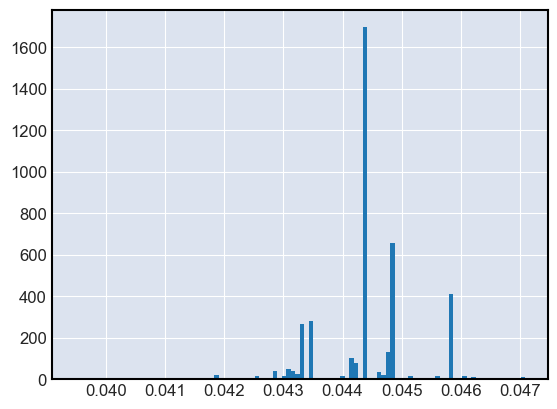

In [357]:
plt.hist(train_predictions,bins=100)
plt.show()

In [359]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
results = run_sim(train_predictions,growth_train,np.percentile(train_predictions,90))
print(f'Results is:{results}')

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = run_sim(test_predictions,growth_test,np.percentile(train_predictions,90))
print(f'Test Results is:{results}')

102/102 [==============================] - 0s 3ms/step
Results is:0.9801979024135052
Test Results is:0.9885813036095903


###### running a simulation

<a id='CNN_candlestick_hl'></a>
## 6.0 Conv2D with color with highs and lows (still no volume)

In [507]:
def convert_time_series_img2(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    #levels = np.arange(lower_bound,upper_bound,resolution)
    #levels = [-np.inf]+levels.tolist()+[np.inf]
    levels = [-np.inf]+np.arange(1-0.001,1+0.002,0.00002).tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,25,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                # plotting the open close candle
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
            
            if h>o:
                for n,y in enumerate(range(o,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<c:
                for n,y in enumerate(range(l,c)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
                        
                
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
                
            if h>c:
                for n,y in enumerate(range(c,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<o:
                for n,y in enumerate(range(l,o)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
    
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img2(series,0.99,1.01,0.0001)
    print(np_img.shape)
    fig, axes = plt.subplots(figsize=(10,5))
    # Padding the image on the sides for plotting purposes
    np_list = list()
    for i in [0,1,2]:
        np_list.append(np.pad(np_img[:,:,i],1))
    np_img_new = np.asarray(np_list)
    dim1 = np_img_new.shape[0]
    dim2 = np_img_new.shape[1]
    dim3 = np_img_new.shape[2]
    l = np_img_new.reshape(dim2,dim3,dim1)
    print(l.shape)
    axes.imshow(np_img)
    plt.tight_layout()
    plt.savefig('test.png',dpi=200)
    plt.show()

(153, 25, 3)
(155, 27, 3)


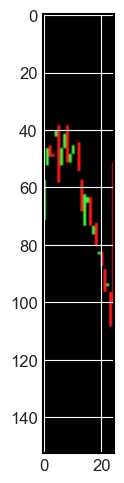

In [508]:
plot_time_series(X_train[18,:,:])

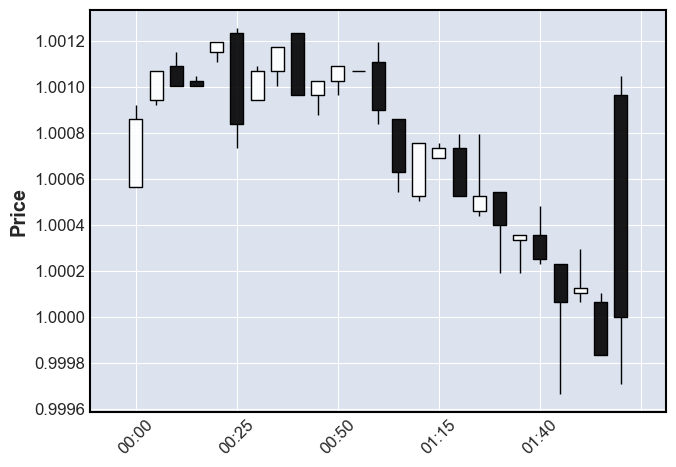

In [436]:
import mplfinance as mpf
intervals = pd.DataFrame(X_train[18,:,:],columns=['volume','close','open','high','low'])
intervals.index = pd.date_range('2021-06-01',periods=len(intervals.index),freq='5min')
mpf.plot(intervals,type='candle')

In [366]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img2(X_train[x,:,:],0.99,1.01,0.0001).astype(np.uint8) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array_color.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [367]:
img_train = np.stack([convert_time_series_img2(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img2(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))])

In [368]:
model = keras.Sequential(
    [
        keras.Input(shape=(302, 25, 3)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.9),
        keras.layers.Dense(200, activation="sigmoid"),
        keras.layers.Dropout(0.9),
        keras.layers.Dense(20, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 300, 23, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 11, 32)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 98, 9, 32)         9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 4, 32)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 2, 64)         18496     
                                                                 
 flatten_10 (Flatten)        (None, 3840)            

In [369]:
batch_size = 200
epochs = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
history = model.fit(img_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(img_test,y_test))

Epoch 1/200


2023-01-29 19:49:51.060176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/20 [===========================>..] - ETA: 0s - loss: 0.2297 - auc: 0.4949

2023-01-29 19:49:52.868787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 94ms/step - loss: 0.2264 - auc: 0.4991 - val_loss: 0.2514 - val_auc: 0.5066
Epoch 2/200
20/20 [==============================] - 1s 67ms/step - loss: 0.1878 - auc: 0.4950 - val_loss: 0.2585 - val_auc: 0.4999
Epoch 3/200
20/20 [==============================] - 1s 64ms/step - loss: 0.1830 - auc: 0.5730 - val_loss: 0.2559 - val_auc: 0.4887
Epoch 4/200
20/20 [==============================] - 1s 64ms/step - loss: 0.1857 - auc: 0.5121 - val_loss: 0.2518 - val_auc: 0.5054
Epoch 5/200
20/20 [==============================] - 1s 66ms/step - loss: 0.1850 - auc: 0.5113 - val_loss: 0.2487 - val_auc: 0.5048
Epoch 6/200
20/20 [==============================] - 1s 64ms/step - loss: 0.1854 - auc: 0.5012 - val_loss: 0.2474 - val_auc: 0.5034
Epoch 7/200
20/20 [==============================] - 1s 65ms/step - loss: 0.1839 - auc: 0.5191 - val_loss: 0.2450 - val_auc: 0.4881
Epoch 8/200
20/20 [==============================] - 1s 64ms/step - loss: 0.1841 - auc: 

Epoch 63/200
20/20 [==============================] - 1s 61ms/step - loss: 0.1826 - auc: 0.5308 - val_loss: 0.2341 - val_auc: 0.5089
Epoch 64/200
20/20 [==============================] - 1s 61ms/step - loss: 0.1822 - auc: 0.5225 - val_loss: 0.2338 - val_auc: 0.5089
Epoch 65/200
20/20 [==============================] - 1s 61ms/step - loss: 0.1821 - auc: 0.4989 - val_loss: 0.2340 - val_auc: 0.5089
Epoch 66/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1828 - auc: 0.5140 - val_loss: 0.2328 - val_auc: 0.5089
Epoch 67/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1829 - auc: 0.5065 - val_loss: 0.2337 - val_auc: 0.5089
Epoch 68/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1826 - auc: 0.5130 - val_loss: 0.2340 - val_auc: 0.5089
Epoch 69/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1823 - auc: 0.5245 - val_loss: 0.2331 - val_auc: 0.5089
Epoch 70/200
20/20 [==============================] - 1s 63ms/step - 

20/20 [==============================] - 1s 62ms/step - loss: 0.1825 - auc: 0.5125 - val_loss: 0.2318 - val_auc: 0.5085
Epoch 125/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1815 - auc: 0.5295 - val_loss: 0.2315 - val_auc: 0.4849
Epoch 126/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1830 - auc: 0.5045 - val_loss: 0.2311 - val_auc: 0.4401
Epoch 127/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1814 - auc: 0.5198 - val_loss: 0.2312 - val_auc: 0.4640
Epoch 128/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1817 - auc: 0.5354 - val_loss: 0.2308 - val_auc: 0.5051
Epoch 129/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1825 - auc: 0.4990 - val_loss: 0.2312 - val_auc: 0.4437
Epoch 130/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1818 - auc: 0.5215 - val_loss: 0.2307 - val_auc: 0.5062
Epoch 131/200
20/20 [==============================] - 1s 62ms/step - loss: 

20/20 [==============================] - 1s 62ms/step - loss: 0.1819 - auc: 0.5043 - val_loss: 0.2297 - val_auc: 0.5090
Epoch 186/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1818 - auc: 0.5067 - val_loss: 0.2294 - val_auc: 0.5090
Epoch 187/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1816 - auc: 0.5576 - val_loss: 0.2300 - val_auc: 0.5090
Epoch 188/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1820 - auc: 0.5177 - val_loss: 0.2299 - val_auc: 0.5090
Epoch 189/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1815 - auc: 0.5252 - val_loss: 0.2299 - val_auc: 0.5090
Epoch 190/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1815 - auc: 0.5206 - val_loss: 0.2296 - val_auc: 0.5090
Epoch 191/200
20/20 [==============================] - 1s 62ms/step - loss: 0.1816 - auc: 0.5395 - val_loss: 0.2307 - val_auc: 0.5098
Epoch 192/200
20/20 [==============================] - 1s 63ms/step - loss: 

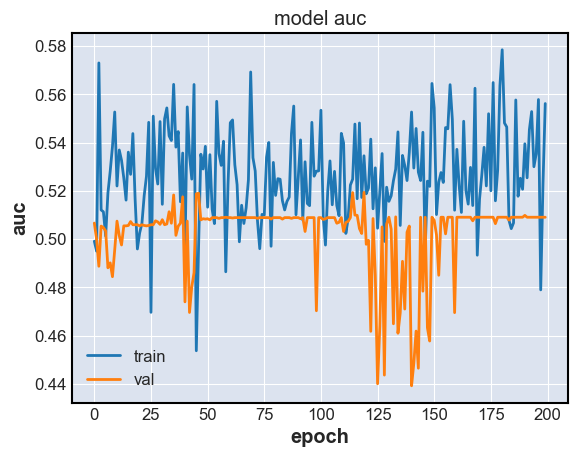

In [370]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

2023-01-29 19:55:18.320982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 1s 4ms/step


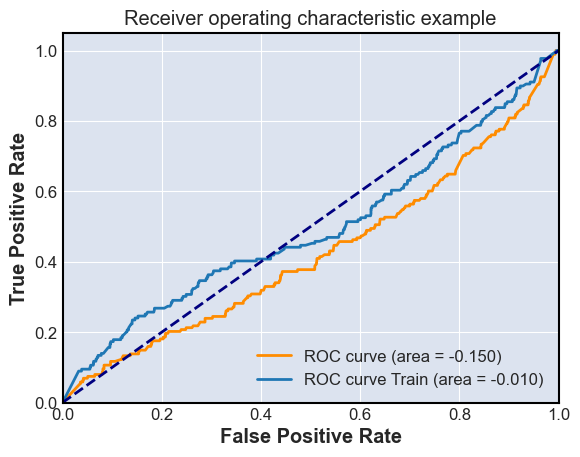

In [371]:
plot_roc_curve(img_train,y_train,img_test,y_test,model)

In [375]:
input_series = X
train_predictions = model.predict(img_train)
test_predictions = model.predict(img_test)

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
results = run_sim(train_predictions,growth_train,np.percentile(train_predictions,90))
print(f'Results is:{results}')

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = run_sim(test_predictions,growth_test,np.percentile(train_predictions,90))
print(f'Test Results is:{results}')

102/102 [==============================] - 0s 4ms/step
Results is:0.9940455338311213
Test Results is:0.9902378266913893


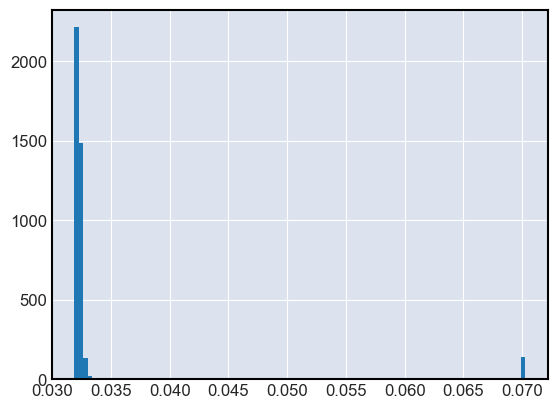

In [374]:
plt.hist(train_predictions,bins=100)
plt.show()

<a id='CNN_candlestick_volume'></a>
## 7.0 Conv2D with color with highs and lows and Volume

Here the model is of the same architecture, albeit the volume is concatenated onto the output of the convolution encoding layers. This means volume is simply a time series.

Other features can be added in this way, such as RSI or moving averages.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from StockPredictionTools import plot_roc_curve, gini

In [408]:
def convert_time_series_img3(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,25,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                # plotting the open close candle
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
            
            if h>o:
                for n,y in enumerate(range(o,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<c:
                for n,y in enumerate(range(l,c)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
                        
                
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
                
            if h>c:
                for n,y in enumerate(range(c,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<o:
                for n,y in enumerate(range(l,o)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img3(series,0.99,1.01,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [377]:
img_train = np.stack([convert_time_series_img3(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))]).astype('float32')
img_test = np.stack([convert_time_series_img3(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))]).astype('float32')

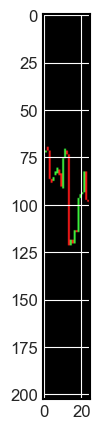

In [409]:
plot_time_series(X_train[50,:,:])

In [410]:
volume_train = X_train[:,:,0]
volume_test = X_test[:,:,0]

In [424]:
class StonkModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        # activate all the layers
        self.conv0 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")
        self.maxpool2D_0 = keras.layers.MaxPooling2D(pool_size=(3, 2))
        self.conv1 = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")
        self.maxpool2D_1 = keras.layers.MaxPooling2D(pool_size=(3, 2))
        #self.conv2 =  keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")
        self.flatten = keras.layers.Flatten()
        self.dropout = keras.layers.Dropout(0.9)
        self.dense = keras.layers.Dense(1, activation="sigmoid")
        
        self.concat =  tf.keras.layers.Concatenate()
        
    
    def call(self, inputs, training=False):
        
        x,v = inputs[0],inputs[1]
        
        # Put the chart through the cnn
        x = self.conv0(x)
        x = self.maxpool2D_0(x)
        #x = self.conv1(x)
        #x = self.maxpool2D_1(x)
        #x = self.conv2(x)
        x = self.flatten(x)
        if training:
            x = self.dropout(x, training=training)
            
        # concatenate with the volume info
        x = self.concat([x,v])
        
        return self.dense(x)
        
        

    def callorig(self, inputs, training=False):
        
        x,v = inputs[0],inputs[1]
        
        # Put the chart through the cnn
        x = self.conv0(x)
        x = self.maxpool2D_0(x)
        x = self.conv1(x)
        x = self.maxpool2D_1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        if training:
            x = self.dropout(x, training=training)
            
        # concatenate with the volume info
        x = self.concat([x,v])
        
        return self.dense(x)

In [425]:
model = StonkModel()
_ = model([img_train,volume_train])

In [426]:
keras.utils.plot_model(model, "my_first_model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [427]:
batch_size = 200
epochs = 40

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
history = model.fit([img_train,volume_train],y_train,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=([img_test,volume_test],y_test))

Epoch 1/40
 1/20 [>.............................] - ETA: 7s - loss: 21.6213 - auc: 0.5069

2023-01-29 23:00:09.820601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/20 [===========================>..] - ETA: 0s - loss: 7.5259 - auc: 0.5067

2023-01-29 23:00:10.697588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 54ms/step - loss: 7.4246 - auc: 0.5037 - val_loss: 4.8624 - val_auc: 0.4987
Epoch 2/40
20/20 [==============================] - 1s 41ms/step - loss: 3.7515 - auc: 0.5092 - val_loss: 3.5446 - val_auc: 0.4969
Epoch 3/40
20/20 [==============================] - 1s 39ms/step - loss: 2.2787 - auc: 0.5388 - val_loss: 2.3428 - val_auc: 0.4957
Epoch 4/40
20/20 [==============================] - 1s 39ms/step - loss: 1.5887 - auc: 0.5668 - val_loss: 1.7340 - val_auc: 0.5006
Epoch 5/40
20/20 [==============================] - 1s 40ms/step - loss: 0.9529 - auc: 0.6265 - val_loss: 1.3257 - val_auc: 0.5024
Epoch 6/40
20/20 [==============================] - 1s 39ms/step - loss: 0.8069 - auc: 0.6164 - val_loss: 1.1722 - val_auc: 0.5052
Epoch 7/40
20/20 [==============================] - 1s 39ms/step - loss: 0.6463 - auc: 0.6589 - val_loss: 1.0183 - val_auc: 0.5062
Epoch 8/40
20/20 [==============================] - 1s 40ms/step - loss: 0.5779 - auc: 0.6630 

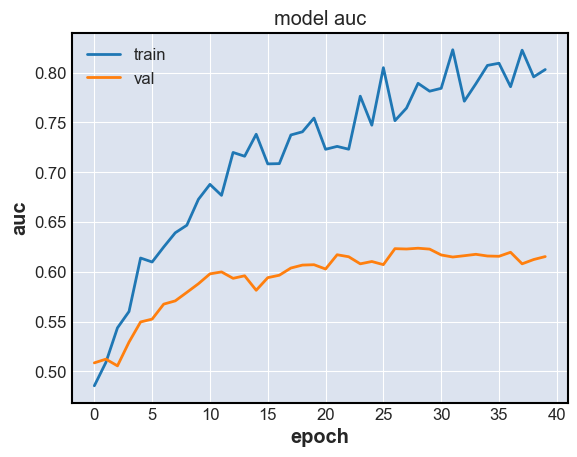

In [420]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

 48/102 [=============>................] - ETA: 0s

2023-01-29 22:47:43.895925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 0s 3ms/step


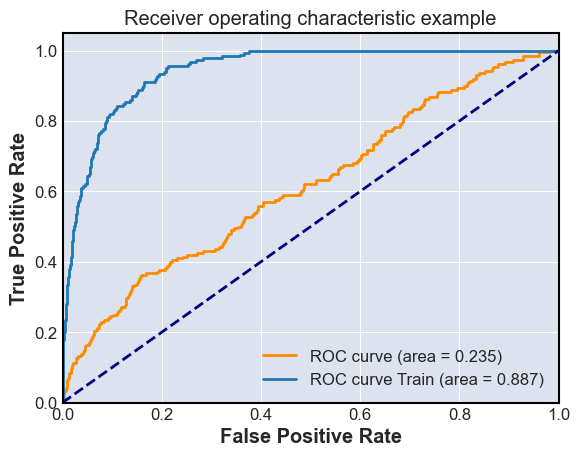

In [421]:
plot_roc_curve([img_train,volume_train],y_train,[img_test,volume_test],y_test,model)

In [422]:
input_series = X
train_predictions = model.predict((img_train,volume_train))
test_predictions = model.predict((img_test,volume_test))

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
results = run_sim(train_predictions,growth_train,np.percentile(train_predictions,90))
print(f'Results is:{results}')

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = run_sim(test_predictions,growth_test,np.percentile(train_predictions,90))
print(f'Test Results is:{results}')

102/102 [==============================] - 0s 3ms/step
Results is:1.1724413430009395
Test Results is:0.9848805613258865


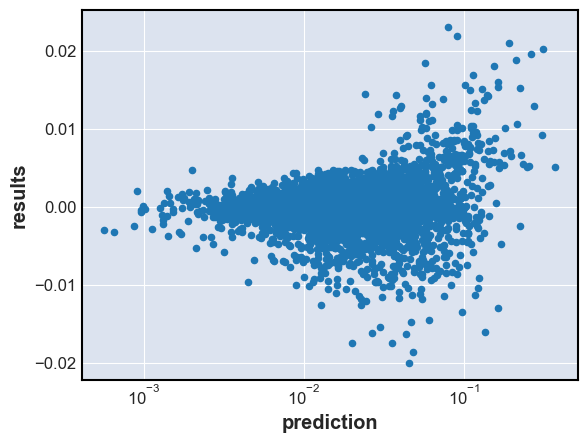

In [423]:
results = pd.DataFrame({'prediction':train_predictions.ravel(),'results':growth_train.ravel()})
results.plot.scatter(x='prediction',y='results')
plt.xscale('log')

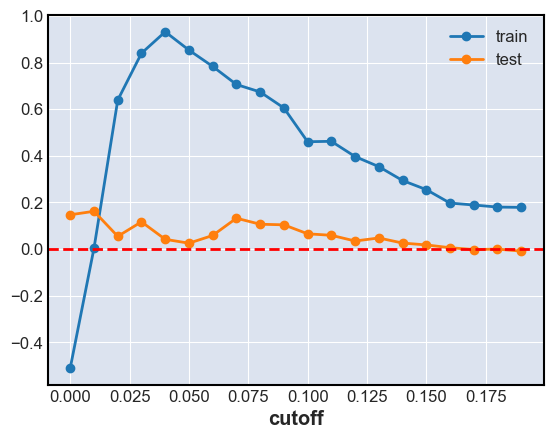

In [405]:
results = pd.DataFrame({'prediction':train_predictions.ravel(),'results':growth_train.ravel()})
profit = list()
for i in np.arange(0,0.2,0.01):
    profit.append({'cutoff':i,'profit_perc':results[results.prediction>=i].results.sum()})
axes = pd.DataFrame.from_records(profit).plot(x='cutoff',y='profit_perc',marker='o',label='train')

profit_test = list()
results_test = pd.DataFrame({'prediction':test_predictions.ravel(),'results':growth_test.ravel()})
for i in np.arange(0,0.2,0.01):
    profit_test.append({'cutoff':i,'profit_perc':results_test[results_test.prediction>=i].results.sum()})
profit_test_df = pd.DataFrame.from_records(profit_test)
profit_test_df.plot(x='cutoff',y='profit_perc',marker='o',label='test',ax=axes)
axes.axhline(0,ls='--',c='r')
plt.show()

In [ ]:
results = pd.DataFrame({'prediction':train_predictions.ravel(),'results':growth_train.ravel()})
profit = list()
for i in np.arange(0,0.2,0.01):
    profit.append({'cutoff':i,'profit_perc':results[results.prediction>=i].sample(frac=0.3).results.sum()})
axes = pd.DataFrame.from_records(profit).plot(x='cutoff',y='profit_perc',marker='o',label='train')

profit_test = list()
results_test = pd.DataFrame({'prediction':test_predictions.ravel(),'results':growth_test.ravel()})
for i in np.arange(0,0.2,0.01):
    profit_test.append({'cutoff':i,'profit_perc':results_test[results_test.prediction>=i].sample(frac=0.3).results.sum()})
profit_test_df = pd.DataFrame.from_records(profit_test)
profit_test_df.plot(x='cutoff',y='profit_perc',marker='o',label='test',ax=axes)
axes.axhline(0,ls='--',c='r')
plt.show()

In [ ]:
# More refined simulation
import tqdm
from collections import defaultdict
portfolio = 1000
countdown_timer = 0
no_intervals = len(img_test)
results = []
probabilities = list()

# Realistically this will be more like 0.00003
spread_cost = 0.0005

records = list()

for n in tqdm.tqdm(range(no_intervals)):
    
    interval_data = [np.expand_dims(img_test[n,:,:,:],axis=0),np.expand_dims(volume_test[n],axis=0)]
    prediction = model.predict(interval_data,verbose=0)
    probabilities.append(prediction.ravel()[0])
    if countdown_timer>0:
        countdown_timer = countdown_timer-1
        results.append(results[-1])
        continue
    
    results.append(portfolio)
    if (prediction>0.05)&(portfolio>0):
        # buy and hold for 30min
        print(f'Bought at iter {n}, result is:{growth_test[n][0]:0.3%}')
        portfolio = portfolio*(1+growth_test[n][0] - spread_cost) 
        countdown_timer = 5
        
        records.append({'prediction':prediction.ravel()[0],'results':growth_test[n][0]})

In [ ]:
fig,axes = plt.subplots(1,1,figsize=[15,6])

file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df[6000:]['close'].reset_index(drop=True).plot(ax=axes,c='red',label='SPY movements',lw=0.5)

axes2 = axes.twinx()
axes2.plot(results,label='portfolio value')
# axes.set_xlabel('iteration')
# axes.set_ylabel('portfolio')
# axes[1].plot(probabilities,c='orange',lw=0.2)
# axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Probability of 0.5% growth in next 30min')
axes.set_ylabel('SPY')
axes2.set_ylabel('Portfolio Value')
plt.legend(['Portfolio','SPY'])
plt.show()

In [ ]:
# More refined simulation
import tqdm
from collections import defaultdict
portfolio = 1000
countdown_timer = 0
no_intervals = len(img_test)
results = []
probabilities = list()

# Realistically this will be more like 0.00003
spread_cost = 0.00003

records = list()

for n in tqdm.tqdm(range(no_intervals)):
    
    interval_data = [np.expand_dims(img_test[n,:,:,:],axis=0),np.expand_dims(volume_test[n],axis=0)]
    prediction = model.predict(interval_data,verbose=0)
    probabilities.append(prediction.ravel()[0])
    if countdown_timer>0:
        countdown_timer = countdown_timer-1
        results.append(results[-1])
        continue
    
    results.append(portfolio)
    if (prediction>0.05)&(portfolio>0):
        # buy and hold for 30min
        print(f'Bought at iter {n}, result is:{growth_test[n][0]:0.3%}')
        portfolio = portfolio*(1+growth_test[n][0] - spread_cost) 
        countdown_timer = 5
        
        records.append({'prediction':prediction.ravel()[0],'results':growth_test[n][0]})

In [ ]:
fig,axes = plt.subplots(1,1,figsize=[15,6])

file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df[6000:]['close'].reset_index(drop=True).plot(ax=axes,c='red',label='SPY movements',lw=0.5)

axes2 = axes.twinx()
axes2.plot(results,label='portfolio value')
# axes.set_xlabel('iteration')
# axes.set_ylabel('portfolio')
# axes[1].plot(probabilities,c='orange',lw=0.2)
# axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Probability of 0.5% growth in next 30min')
axes.set_ylabel('SPY')
axes2.set_ylabel('Portfolio Value')
plt.legend(['Portfolio','SPY'])
plt.show()

Market Made 1.7% gains, whereas the model got 3.5%.

In [ ]:
df[6000:]['close'].iloc[-1]/df[6000:]['close'].iloc[0]

In [ ]:
results[-1]/results[0]

In [ ]:
# More refined simulation
import tqdm
from collections import defaultdict
portfolio = 1000
countdown_timer = 0
no_intervals = len(img_test)
results = []
probabilities = list()

# Realistically this will be more like 0.00003
spread_cost = 0.00006

records = list()

for n in tqdm.tqdm(range(no_intervals)):
    
    interval_data = [np.expand_dims(img_test[n,:,:,:],axis=0),np.expand_dims(volume_test[n],axis=0)]
    prediction = model.predict(interval_data,verbose=0)
    probabilities.append(prediction.ravel()[0])
    if countdown_timer>0:
        countdown_timer = countdown_timer-1
        results.append(results[-1])
        continue
    
    results.append(portfolio)
    if (prediction>0.05)&(portfolio>0):
        # buy and hold for 30min
        print(f'Bought at iter {n}, result is:{growth_test[n][0]:0.3%}')
        portfolio = portfolio*(1+growth_test[n][0] - spread_cost) 
        countdown_timer = 5
        
        records.append({'prediction':prediction.ravel()[0],'results':growth_test[n][0]})

In [ ]:
fig,axes = plt.subplots(1,1,figsize=[15,6])

file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df[6000:]['close'].reset_index(drop=True).plot(ax=axes,c='red',label='SPY movements',lw=0.5)

axes2 = axes.twinx()
axes2.plot(results,label='portfolio value')
# axes.set_xlabel('iteration')
# axes.set_ylabel('portfolio')
# axes[1].plot(probabilities,c='orange',lw=0.2)
# axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Probability of 0.5% growth in next 30min')
axes.set_ylabel('SPY')
axes2.set_ylabel('Portfolio Value')
plt.legend(['Portfolio','SPY'])
plt.show()

Market Made 1.7% gains, whereas the model got 2.6%

In [ ]:
df[6000:]['close'].iloc[-1]/df[6000:]['close'].iloc[0]

In [ ]:
results[-1]/results[0]

In [ ]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from StockPredictionTools import plot_roc_curve, gini

In [ ]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()

# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<41:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-40:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+6,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1
    
y = np.array(y).reshape(-1,1)
growth = np.array(growth).reshape(-1,1)
X = np.stack(X)

X_train = X[:6000].astype('float32')
X_test = X[6000:].astype('float32')

y_train = y[:6000].astype('float32')
y_test = y[6000:].astype('float32')

growth_train = growth[:6000].astype('float32')
growth_test = growth[6000:].astype('float32')

In [ ]:
X_train.shape

In [ ]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,41,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                # plotting the open close candle
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
            
            if h>o:
                for n,y in enumerate(range(o,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<c:
                for n,y in enumerate(range(l,c)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
                        
                
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
                
            if h>c:
                for n,y in enumerate(range(c,h)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 255
                        blank[y,x,1] = 100
                        blank[y,x,2] = 255
                        
            if l<o:
                for n,y in enumerate(range(l,o)):
                    # plotting the high candle
                    if n==0:
                        pass
                    else:
                        blank[y,x,0] = 100
                        blank[y,x,1] = 255
                        blank[y,x,2] = 100
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img(series,0.99,1.01,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [ ]:
img_train = np.stack([convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))]).astype('float32')
img_test = np.stack([convert_time_series_img(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))]).astype('float32')

In [ ]:
volume_train = X_train[:,:,0]
volume_test = X_test[:,:,0]

In [ ]:
class StonkModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        # activate all the layers
        self.conv0 = keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu")
        self.maxpool2D_0 = keras.layers.MaxPooling2D(pool_size=(3, 2))
#        self.batchnorm0 = keras.layers.BatchNormalization()
        
        self.conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")
        self.maxpool2D_1 = keras.layers.MaxPooling2D(pool_size=(3, 2))
#        self.batchnorm1 = keras.layers.BatchNormalization()
        
#         self.conv2 =  keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")
#         self.maxpool2D_2 = keras.layers.MaxPooling2D(pool_size=(3, 2))
#         self.batchnorm2 = keras.layers.BatchNormalization()
        
        
        self.flatten = keras.layers.Flatten()
        self.dropout = keras.layers.Dropout(0.9)
        self.dense = keras.layers.Dense(1, activation="sigmoid")
        
        self.concat =  tf.keras.layers.Concatenate()
        
        

    def call(self, inputs, training=False):
        
        x,v = inputs[0],inputs[1]
        
        # Put the chart through the cnn
        x = self.conv0(x)
        x = self.maxpool2D_0(x)
#         x = self.batchnorm0(x)
        
        x = self.conv1(x)
        x = self.maxpool2D_1(x)
#         x = self.batchnorm1(x)
        
#         x = self.conv2(x)
#         x = self.maxpool2D_2(x)
#         x = self.batchnorm2(x)
        
        x = self.flatten(x)
        if training:
            x = self.dropout(x, training=training)
            
        # concatenate with the volume info
        x = self.concat([x,v])
        
        return self.dense(x)

In [ ]:
model = StonkModel()
_ = model([img_train,volume_train])

In [ ]:
img_train.shape

In [ ]:
batch_size = 200
epochs = 20

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=30,
    decay_rate=0.90)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[tf.metrics.AUC(name='auc')])
my_callbacks = [keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]

history = model.fit([img_train,volume_train],y_train,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=([img_test,volume_test],y_test),callbacks=my_callbacks)

In [ ]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [ ]:
plot_roc_curve([img_train,volume_train],y_train,[img_test,volume_test],y_test,model)

In [ ]:
input_series = X
train_predictions = model.predict([img_train,volume_train])
test_predictions = model.predict([img_test,volume_test])

# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(train_predictions>percentiles[0],100,0)
results = bet_amount*growth_train
print(f'Results is:{results.sum()}')

In [ ]:
# Cut the distribution up into percentiles
percentiles = np.percentile(train_predictions,[90])

# if in the top 10 percentiles then put a bet on of £100
bet_amount = np.where(test_predictions>percentiles[0],100,0)
results = bet_amount*growth_test
print(f'Test Results is:{results.sum()}')